In [2]:
import os
import re
from dotenv import load_dotenv, find_dotenv
from pprint import pprint
import base64
import json
import mimetypes
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# Define Category and File names

In [4]:
# do it for each category, dress, outerwear
fashion_category = "dress"

# Specify the path of images
category_folder_path = f"C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/threadup/{fashion_category}/"

# Specify the csv filename to store captions
captions_csv = f'thread_descriptions_{fashion_category}.csv'

#for visualizing data from csv files
captions_csv_path = os.path.join(category_folder_path, captions_csv)

#max tokens for caption from payload function
max_tokens = 300

# API key

In [4]:
## access to API key
notebook_directory = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images"

# Construct the absolute path to the api.env file
env_file_path = os.path.join(notebook_directory, "api.env")

# Load environment variables from the api.env file
load_dotenv(env_file_path, override=True)

# Access the API key
api_key = os.getenv("OPENAI_API_KEY")

In [5]:
# !setx OPENAI_API_KEY api_key

os.environ['OPENAI_API_KEY'] = api_key

# Functions for OPENAI aPI

In [5]:
def encode_image(image_path: str):
    """Encodes an image to base64 and determines the correct MIME type."""
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        raise ValueError(f"Cannot determine MIME type for {image_path}")

    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        return f"data:{mime_type};base64,{encoded_string}"


def create_payload(images: list[str], prompt: str, model="gpt-4-vision-preview", max_tokens=max_tokens, detail="high"):
    """Creates the payload for the API request."""
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        },
    ]

    for image in images:
        base64_image = encode_image(image)
        messages[0]["content"].append({
            "type": "image_url",
            "image_url": {
                "url": base64_image,
                "detail": detail,
            }
        })

    return {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens
    }


def query_openai(payload):
    """Sends a request to the OpenAI API and prints the response."""
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

In [6]:
# List all files in the folder
files_in_folder = os.listdir(category_folder_path)

# Create a list to store the paths of the JPEG images
image_paths = [os.path.join(category_folder_path, file) for file in files_in_folder if file.endswith('.jpg')]


# Prompt

In [7]:
selected_image_paths = image_paths[:200]

# Assuming image_paths is already populated
responses = []

prompt = f'''Please describe this {fashion_category}. It is crucial that your description includes all of the following subcategories without missing any. Each subcategory should be addressed separately and in the order listed below:
 
- Overall Description: [Provide a concise overall description of the item including color, vibe, material and any other key details in one sentence]
- Specific Category: [Provide the specific type of item]
- Color: [Succinctly describe the color(s), including shade, intensity and any patterns]
- Material: [Succinctly describe the material, including fabric type and weave if visible]
- Features: [Mention any notable features such as closures, pockets, or specific design elements like sleeve type, collar shape, or cuff style when these are a defining feature of the item.]
- Vibe: [Succinctly describe the vibe, indicating if the item is bohemian, modern, futuristic, edgy, classic, romantic, or any other specific aesthetic]
- Cut: [Succinctly describe the style, including cut and fit]
- Occasion: [Succinctly state the suitable occasion for wearing the item]

For example:

- Overall Description: A knee-length summer dress featuring a floral pattern with yellow and burgundy flowers on an off-white background.
- Specific Category: Summer dress.
- Color: The base color is off-white, overlaid with a floral pattern that includes shades of yellow, burgundy, and dark green.
- Material: Lightweight fabric, likely a cotton blend, with a smooth texture.
- Features: V-neckline, fluttery sleeves, concealed back zipper  
- Vibe:  A romantic and feminine vibe.
- Cut:  A fit-and-flare style that hits just above the knee.
- Occasion: Suitable for casual summer outings, such as picnics, beach visits, or daytime garden parties.

Your description should match this format and level of detail. Please ensure that each subcategory starts on a new line for clarity and that no subcategory is left unaddressed.
'''

for img_path in selected_image_paths:
    # Create payload for each image
    payload = create_payload([img_path], prompt)

    # Query the OpenAI API
    response = query_openai(payload)

    # Extract the relevant part of the response
    description = response['choices'][0]['message']['content']
    
    # Store the response and corresponding filename
    responses.append({
        "filename": os.path.basename(img_path),
        "description": description
    })

# Convert the responses list to a DataFrame
responses_df = pd.DataFrame(responses)

if os.path.exists(captions_csv_path):
    responses_df.to_csv(captions_csv_path, mode='a', header=False, index=False)
else:
# Save to CSV
    responses_df.to_csv(captions_csv_path, index=False)

In [ ]:
# Print or process the responses
for item in responses[105:108]:
    print(f"Filename: {item['filename']}\nDescription: {item['description']}\n")

In [21]:
import random
import shutil
random_ix = random.sample(range(55, len(captions)), 20)
destination_folder = os.path.join(category_folder_path, 'selected_images_human_captioning')

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)


for item in random_ix:
    source_file = os.path.join(category_folder_path, captions["filename"][item]) 
    # Copy the file to the new location
    shutil.copy(source_file, destination_folder)

# Visualize images and captions from OPENAI

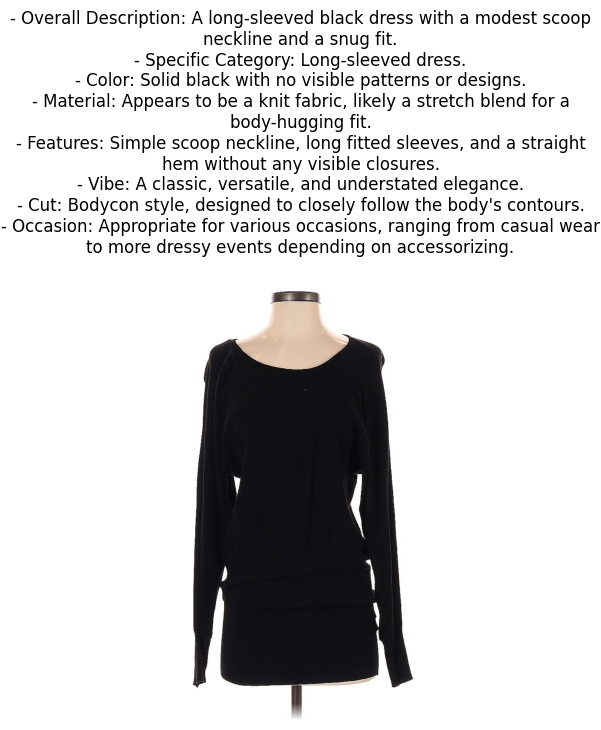

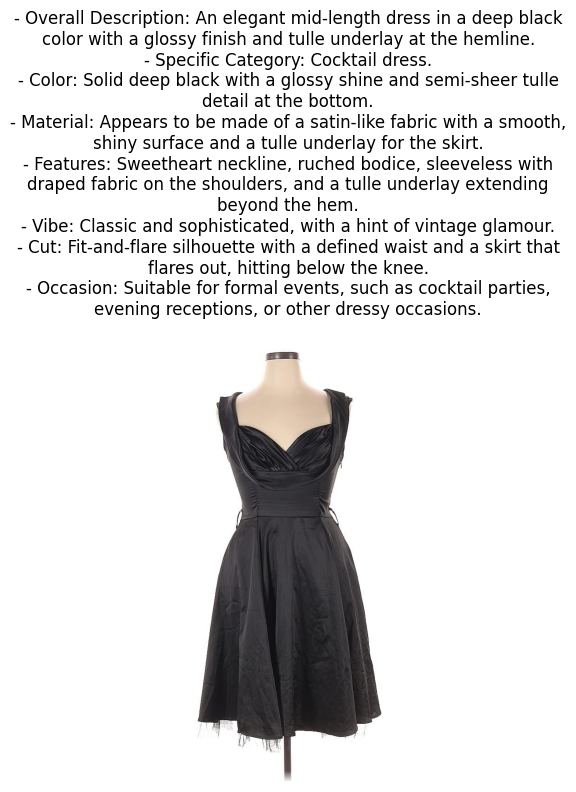

In [8]:
captions = pd.read_csv(captions_csv_path)


# Iterate over the responses and display each image with its description
for item in range(0, 2):
    
    img_path = os.path.join(category_folder_path, captions["filename"][item]) 
    
    # Open the image
    img = Image.open(img_path)

    # Set up the matplotlib figure
    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks

    # Display the description
    plt.title(captions["description"][item], wrap=True)

    # Show the plot
    plt.show()